## 1. harris corner detection

In [1]:
# 导入相应依赖
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

### 1.1  图像灰度化——使用NTSC公式
NTSC (National Television System Committee) 是美国电视制式的标准，其中定义了图像的亮度计算公式：
$$Y = 0.299 R + 0.587 G + 0.114 B$$

In [3]:
def rgb2gray(rgb):
    gray = np.dot(rgb[..., :3], [0.299, 0.587, 0.114])
    gray = np.clip(gray, 0, 255).astype(np.uint8)

    return gray

读取lena图像并对齐进行灰度化处理

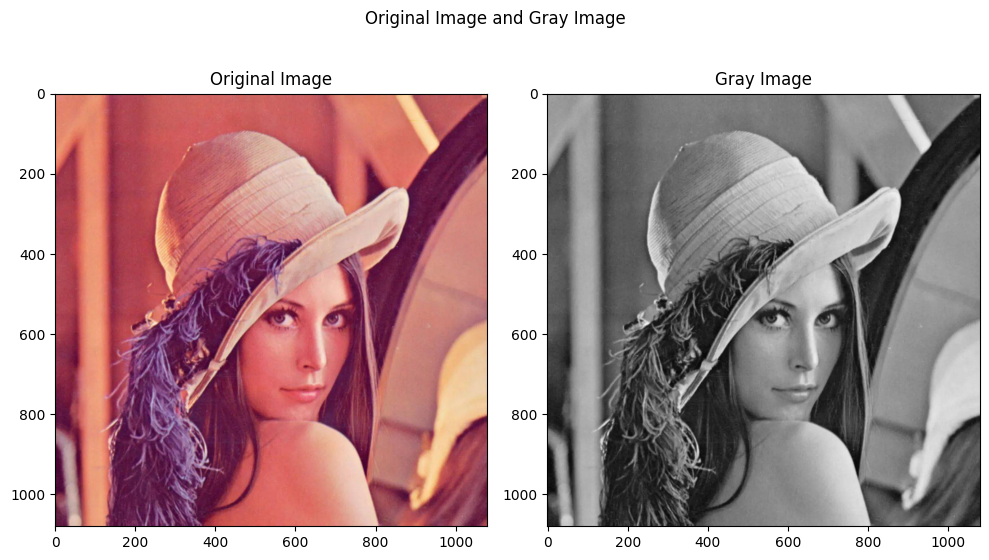

In [4]:
img_1 = cv2.imread('img/lena.jpg')
img_1 = img_1[:, :, [2, 1, 0]] # BGR -> RGB
img_1_gray = rgb2gray(img_1)

plt.figure(figsize=(10, 10))
plt.subplot(121)
# rgb格式显示原始图像
plt.imshow(img_1)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(img_1_gray, cmap='gray')
plt.title('Gray Image')
plt.tight_layout()
plt.suptitle("Original Image and Gray Image", y=0.8)
plt.show()

### 1.2 计算图像梯度
使用 Sobel 算子与图像卷积，计算图像的梯度，sobel 算子的计算公式如下：
$$G_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix} 
\quad G_y = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{bmatrix}$$

其中，$G_x$ 和 $G_y$ 分别表示图像在 $x$ 方向和 $y$ 方向的梯度，$I$ 表示图像灰度矩阵。


仅使用numpy自定义卷积函数，填充方式默认为zero填充，可选edge和valid，same填充为边缘填充，valid为不填充；可指定返回值类型，默认返回值为卷积后的图像（uint8)。

In [5]:
def convolve2d(image, kernel, mode='zero', data_type=np.uint8):
    if mode == 'zero':
        img_pad = np.pad(
            image, (kernel.shape[0]//2, ), 'constant', constant_values=0)
    elif mode == 'edge':
        img_pad = np.pad(image, (kernel.shape[0]//2, ), 'edge')
    elif mode == 'valid':
        img_pad = image
    else:
        raise ValueError("mode must be 'zero', 'edge' or 'valid'")
    output = np.zeros_like(image).astype(np.float32)

    for row in range(output.shape[0]):
        for col in range(output.shape[1]):
            output[row, col] = (
                kernel * img_pad[row:row + kernel.shape[0], col:col + kernel.shape[1]]).sum()
    if data_type == np.uint8: 
        output = np.clip(output, 0, 255).astype(np.uint8)
    else:
        output = output.astype(data_type)
    return output

对灰度化后的lena图像计算梯度，使用sobel算子

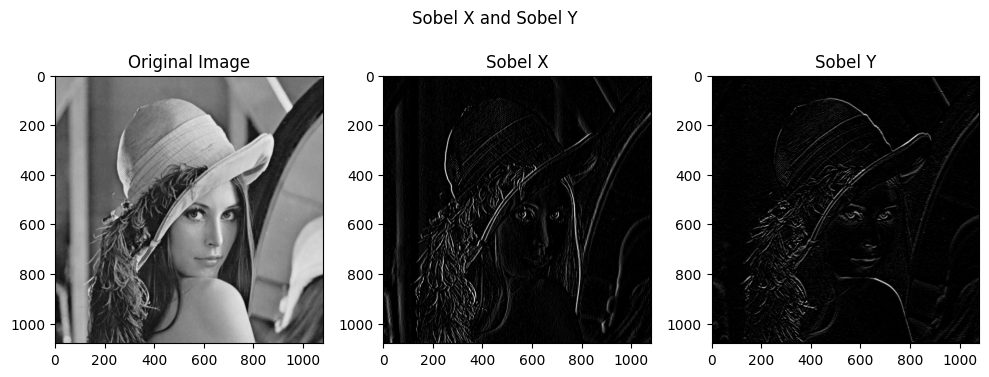

In [6]:
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

img_1_sobel_x = convolve2d(img_1_gray, sobel_x, mode='zero')
img_1_sobel_y = convolve2d(img_1_gray, sobel_y, mode='zero')

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(img_1_gray, cmap='gray')
plt.title('Original Image')
plt.subplot(132)
plt.imshow(img_1_sobel_x, cmap='gray')
plt.title('Sobel X')
plt.subplot(133)
plt.imshow(img_1_sobel_y, cmap='gray')
plt.title('Sobel Y')
plt.tight_layout()
plt.suptitle("Sobel X and Sobel Y", y=0.7)
plt.show()

### 1.3 计算梯度的乘积
计算梯度的乘积 $I^2_x, I^2_y, I_xI_y$，其中 $I_x$ 和 $I_y$ 分别表示图像在 $x$ 方向和 $y$ 方向的梯度，$I$ 表示图像灰度矩阵。这里需要对数据类型进行转换，否则会出现数据溢出的情况。

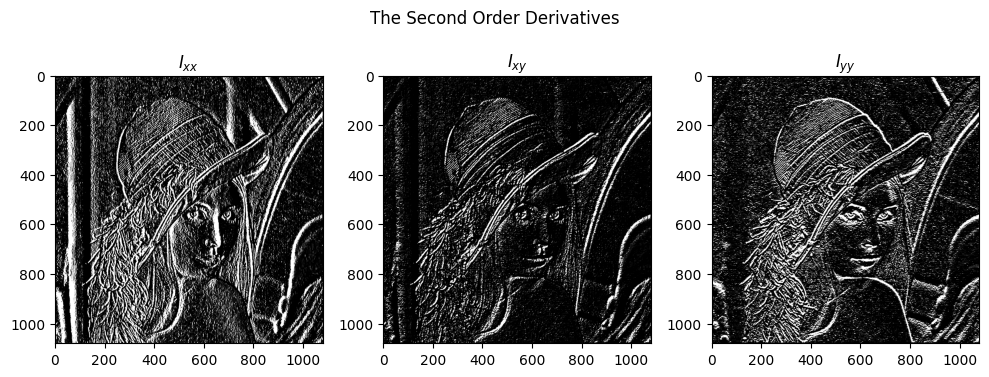

In [7]:
I_xx = np.float32(img_1_sobel_x) * np.float32(img_1_sobel_x)
I_xy = np.float32(img_1_sobel_x) * np.float32(img_1_sobel_y)
I_yy = np.float32(img_1_sobel_y) * np.float32(img_1_sobel_y)
I_xx = np.clip(I_xx, 0, 255).astype(np.uint8)
I_xy = np.clip(I_xy, 0, 255).astype(np.uint8)
I_yy = np.clip(I_yy, 0, 255).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(I_xx, cmap='gray')
plt.title('$I_{xx}$')
plt.subplot(132)
plt.imshow(I_xy, cmap='gray')
plt.title('$I_{xy}$')
plt.subplot(133)
plt.imshow(I_yy, cmap='gray')
plt.title('$I_{yy}$')
plt.tight_layout()
# 总标题与子图之间的距离
plt.suptitle("The Second Order Derivatives", y=0.7)
plt.show()

### 1.4 对梯度乘积进行高斯滤波
对梯度乘积进行高斯滤波，使用高斯滤波器的计算公式如下：
$$G(x,y) = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}$$

其中，$\sigma$ 表示高斯滤波器的标准差。

In [8]:
# 定义高斯核函数
def gaussian_kernel(sigma, size=None):
    if size is None:
        size = int(sigma * 6 + 1)
        size = size if size % 2 else size + 1
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    kernel = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return kernel

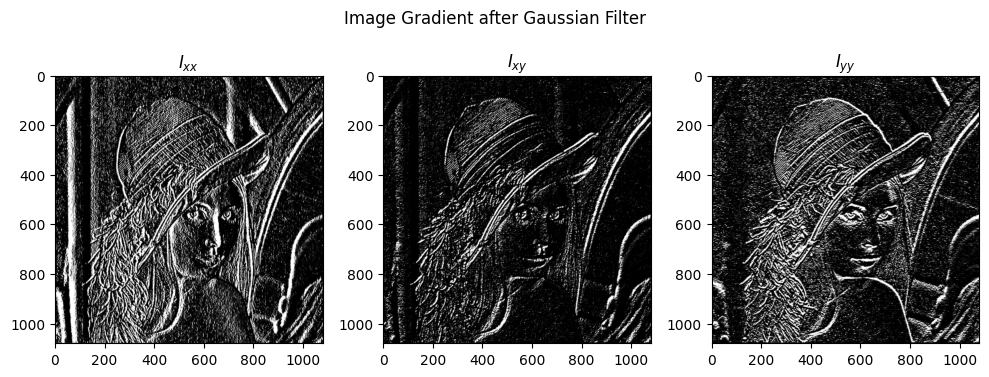

In [9]:
# 定义大小为3的，标准差为1的高斯核
gaussian_kernel_3 = gaussian_kernel(1, 3)

# 对I_xx, I_xy, I_yy进行高斯滤波
I_xx = convolve2d(I_xx, gaussian_kernel_3, mode='zero')
I_xy = convolve2d(I_xy, gaussian_kernel_3, mode='zero')
I_yy = convolve2d(I_yy, gaussian_kernel_3, mode='zero')

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(I_xx, cmap='gray')
plt.title('$I_{xx}$')
plt.subplot(132)
plt.imshow(I_xy, cmap='gray')
plt.title('$I_{xy}$')
plt.subplot(133)
plt.imshow(I_yy, cmap='gray')
plt.title('$I_{yy}$')
plt.tight_layout()
plt.suptitle('Image Gradient after Gaussian Filter', y=0.7)
plt.show()


### 1.5 计算角点响应

角点响应的计算公式如下：
$$R = det(M) - k(trace(M))^2$$

其中，$M$ 表示梯度乘积的高斯滤波结果，$k$ 是一个常数，通常取 $0.04$。

In [10]:
def compute_R(I_xx, I_xy, I_yy):
    R = np.zeros_like(I_xx).astype(np.float32)
    for row in range(R.shape[0]):
        for col in range(R.shape[1]):
            M = np.array([[I_xx[row, col], I_xy[row, col]], [I_xy[row, col], I_yy[row, col]]]).astype(np.float32)
            R[row, col] = np.linalg.det(M) - 0.04 * np.trace(M)**2
    return R

In [11]:
# 计算R
R = compute_R(I_xx, I_xy, I_yy)
R

array([[ 1.94900e+03,  2.31836e+03, -3.40160e+02, ..., -3.45960e+02,
        -3.53440e+02, -1.90440e+02],
       [ 2.31836e+03,  2.37824e+03,  1.71840e+02, ..., -1.44000e+02,
        -1.53760e+02, -8.10000e+01],
       [-3.40160e+02,  1.71840e+02,  4.19600e+01, ..., -3.60000e-01,
        -6.40000e-01, -3.60000e-01],
       ...,
       [-8.38316e+03, -3.72116e+03, -1.85600e+01, ...,  4.13440e+02,
         4.37760e+02,  1.16240e+02],
       [-4.52544e+03, -1.96036e+03, -1.90000e+01, ..., -2.11600e+01,
         4.80000e+01,  1.97600e+01],
       [-8.04560e+02, -3.04040e+02,  4.36000e+00, ..., -2.59600e+01,
         4.96000e+00,  3.44000e+00]], dtype=float32)

### 1.6 非极大值抑制和阈值处理

非极大值抑制是指对角点响应矩阵进行遍历，对于每一个像素，如果其值大于其周围 $8$ 个像素的值，则保留该像素，否则将其置为 $0$。阈值处理是指对角点响应矩阵进行遍历，对于每一个像素，如果其值大于阈值，则保留该像素，否则将其置为 $0$。

In [12]:
def non_maximum_suppression(R, threshold, window_size=3):
    rows, cols = R.shape
    R_max = np.zeros((rows, cols))
    for i in range(0, rows - window_size + 1, window_size):
        for j in range(0, cols - window_size + 1, window_size):
            window = R[i:i+window_size, j:j+window_size]
            max_val = np.max(window)
            R_max[i:i+window_size, j:j+window_size] = (window == max_val) * max_val
    # 阈值化
    R_max[R_max < threshold * np.max(R_max)] = 0 

    R_max = np.clip(R_max, 0, 255).astype(np.uint8)
    R_max[R_max > 0] = 255

    return R_max

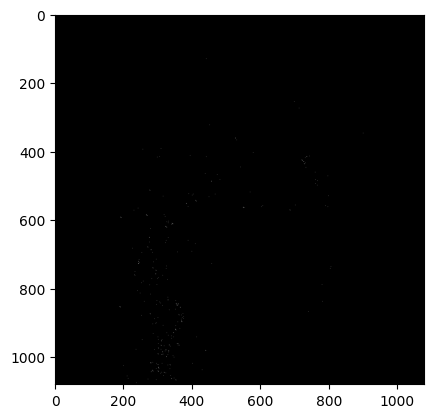

In [13]:
corner = non_maximum_suppression(R, 0.8, 2)
plt.imshow(corner, cmap='gray')

### 1.7 结果展示

在原图上绘制角点

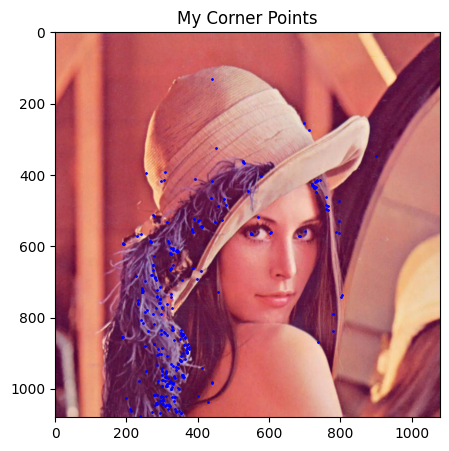

In [14]:
# 画出角点
plt.figure(figsize=(5, 5))
plt.imshow(img_1, cmap='gray')
plt.scatter(np.where(corner > 0)[1], np.where(corner > 0)[0], c='b', s=1)
plt.title('My Corner Points')
plt.show()

## 2. opencv实现

### 2.1 使用opencv实现harris角点检测

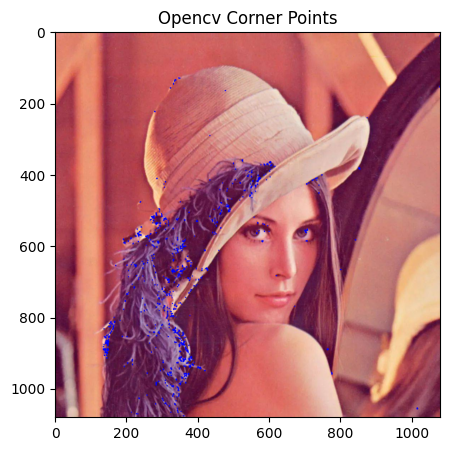

In [15]:
# 使用OpenCV实现Harris角点检测
img_1_gray = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
img_1_gray = np.float32(img_1_gray)
dst = cv2.cornerHarris(img_1_gray, 2, 3, 0.04)
dst = cv2.dilate(dst, None)
img_1[dst > 0.02 * dst.max()] = [0, 0, 255]

plt.figure(figsize=(5, 5))
plt.imshow(img_1)
plt.title('Opencv Corner Points')
plt.show()